In [47]:
import pandas as pd

weather = pd.read_csv("../Data/madrid_weather.csv", parse_dates=["time"])

weather.head()

,time,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
0,2019-01-01 00:59:00,3.1,0.65,64,50,949,0,0.0
1,2019-01-01 01:59:00,2.9,0.95,32,49,949,0,0.0
2,2019-01-01 02:59:00,3.1,0.87,62,46,949,0,0.0
3,2019-01-01 03:59:00,1.9,0.73,75,51,949,0,0.0
4,2019-01-01 04:59:00,0.7,0.57,53,56,949,0,0.0


### EDA & Smoothing

<Axes: xlabel='time'>

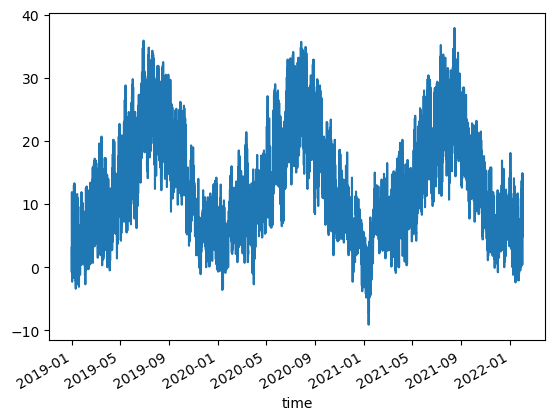

In [48]:
weather.set_index("time").loc[:, "temperature"].plot()

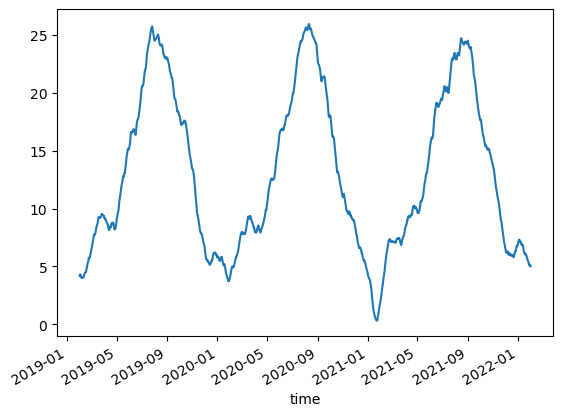

In [49]:
# 24 = daily moving average
# (24 * 30) = 30-day moving average
# (24 * 365) = yearly moving average


weather.set_index("time").loc[:, "temperature"].rolling((24 * 30)).mean().plot();

### Decomposition

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

taco_stands = pd.read_csv("../Data/taco_stands.csv", parse_dates=["Date"])

taco_stands.head()

,Date,Taco Stands in LA
0,2010-01-01,12
1,2010-02-01,15
2,2010-03-01,15
3,2010-04-01,19
4,2010-05-01,24


<Axes: xlabel='Date'>

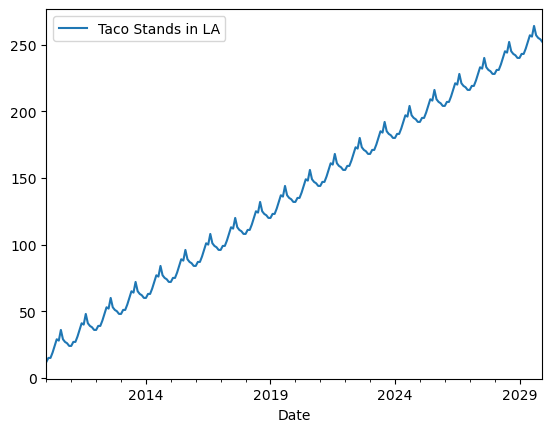

In [52]:
taco_stands.set_index("Date").plot()

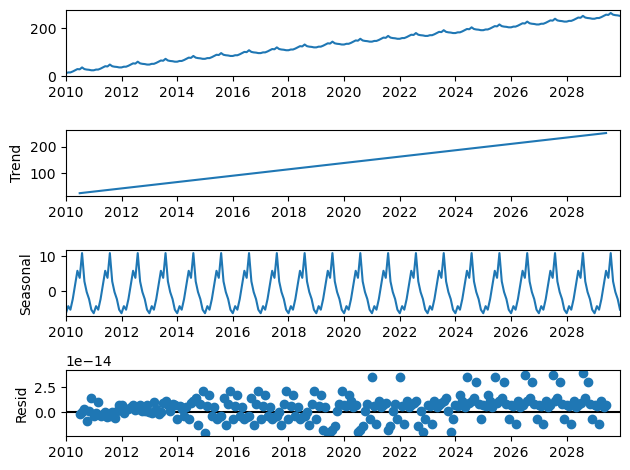

In [12]:
seasonal_decompose(taco_stands.set_index("Date")).plot();

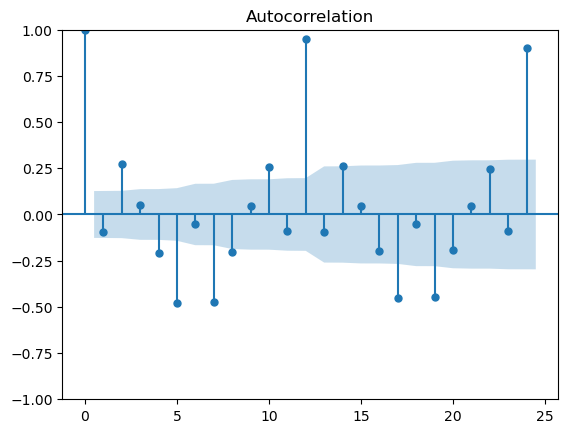

In [57]:
from statsmodels.graphics.tsaplots import plot_acf

# Need to difference our series to remove trend, slicing off missing value to plot

plot_acf(taco_stands["Taco Stands in LA"].diff()[1:]);

### Linear Regression

In [16]:
monthly_weather =(
    weather
    .set_index("time")
    .resample("M")
    .agg({"temperature": "mean"})
    .reset_index()
)

monthly_weather.tail()

,time,temperature
32,2021-09-30,17.679583
33,2021-10-31,13.863306
34,2021-11-30,6.686667
35,2021-12-31,6.859140
36,2022-01-31,5.027500


In [17]:
# Create Trend and Seasonal Variables

monthly_weather = monthly_weather.assign(
    trend = monthly_weather.index,
    month = monthly_weather["time"].dt.month.astype("object")
)

monthly_weather.head()

,time,temperature,trend,month
0,2019-01-31,4.267473,0,1
1,2019-02-28,6.645982,1,2
2,2019-03-31,9.244489,2,3
3,2019-04-30,9.032222,3,4
4,2019-05-31,15.345968,4,5


In [18]:
# Get Seasonal Dummies

monthly_weather = pd.get_dummies(monthly_weather, drop_first=True)

monthly_weather.tail()

/var/folders/f8/075hbnj13wb0f9yzh9k4nyz00000gn/T/ipykernel_26876/201655778.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  monthly_weather = pd.get_dummies(monthly_weather, drop_first=True)


,time,temperature,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
32,2021-09-30,17.679583,32,0,0,0,0,0,0,0,1,0,0,0
33,2021-10-31,13.863306,33,0,0,0,0,0,0,0,0,1,0,0
34,2021-11-30,6.686667,34,0,0,0,0,0,0,0,0,0,1,0
35,2021-12-31,6.859140,35,0,0,0,0,0,0,0,0,0,0,1
36,2022-01-31,5.027500,36,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Split Data Based on Time

weather_train = monthly_weather.set_index("time").loc[:"2021-09"]
weather_test = monthly_weather.set_index("time").loc["2021-10-31":]

weather_test

KeyError: "None of ['time'] are in the columns"

In [20]:
# Fit Regression

import statsmodels.api as sm

y = weather_train["temperature"]
X = sm.add_constant(weather_train.iloc[:, 1:]).drop("trend", axis=1)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     185.2
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           2.49e-18
Time:                        13:53:03   Log-Likelihood:                -35.354
No. Observations:                  33   AIC:                             94.71
Df Residuals:                      21   BIC:                             112.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4596      0.511      6.767      0.000       2.396       4.523
month_2        3.8127      0.723      5.273      0.000       2.309       5.316
month_3        4.9670      0.723      6.870      0.000       3.463       6.471
month_4        6.3075      0.723      8.724      0.000       4.804       7.811
month_5       12.1780      0.723     16.844      0.000      10.674      13.682
month_6       16.3477      0.723     22.611      0.000      14.844      17.851
month_7       20.9677      0.723     29.001      0.000      19.464      22.471
month_8       19.9664      0.723     27.616      0.000      18.463      21.470
month_9       14.4522      0.723     19.989      0.000      12.949      15.956
month_10       8.9074      0.808     11.019      0.000       7.226      10.588
month_11       4.0950      0.808      5.066      0.000       2.414       5.776
month_12       1.6279      0.808      2.014      0.057      -0.053       3.309
==============================================================================
Omnibus:                        3.755   Durbin-Watson:                   2.503
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                1.617
Skew:                          -0.108   Prob(JB):                        0.446
Kurtosis:                       1.937   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# Make Predictions

y_test = weather_test["temperature"]
X_test = sm.add_constant(weather_test.iloc[:, 1:]).drop("trend", axis=1)

prediction = model.predict(X_test)

prediction

time
2021-10-31    12.367070
2021-11-30     7.554583
2021-12-31     5.087500
2022-01-31     3.459633
dtype: float64

In [22]:
# Predictions vs. Actual DataFrame

pred_df = pd.DataFrame({"actual": y_test, "predicted": prediction})

pred_df

,actual,predicted
time,,
2021-10-31,13.863306,12.367070
2021-11-30,6.686667,7.554583
2021-12-31,6.859140,5.087500
2022-01-31,5.027500,3.459633


In [23]:
# Performance Metrics

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

print(mape(pred_df["actual"], pred_df["predicted"]))
print(mae(pred_df["actual"], pred_df["predicted"]))

0.20196827677219284
1.4259150985663096


<Axes: xlabel='time'>

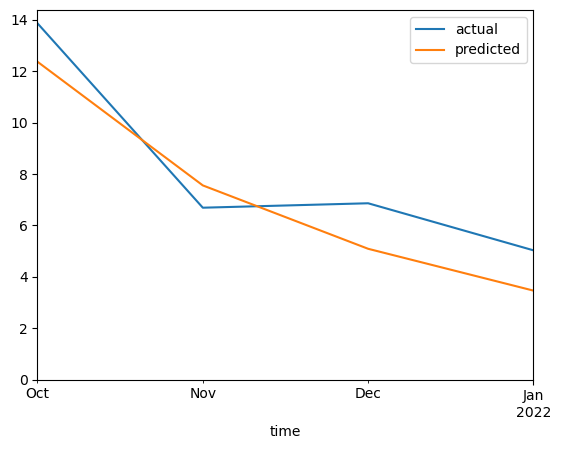

In [35]:
## Forecast Chart

pred_df.plot(ylim=0)

## Facebook Prophet

In [42]:
# Reshape Dataframe into Facebook Prophet Data

monthly_weather = (
    weather
    .set_index("time")
    .resample("M")
    .agg({"temperature": "mean"})
    .reset_index()
    .rename({"time": "ds", "temperature": "y"}, axis=1)
)

monthly_weather.head()

,ds,y
0,2019-01-31,4.267473
1,2019-02-28,6.645982
2,2019-03-31,9.244489
3,2019-04-30,9.032222
4,2019-05-31,15.345968


In [45]:
# Split Data

monthly_weather_train = monthly_weather[:-4]
monthly_weather_test = monthly_weather[-4:]

monthly_weather_test

,ds,y
33,2021-10-31,13.863306
34,2021-11-30,6.686667
35,2021-12-31,6.859140
36,2022-01-31,5.027500


In [46]:
#!conda install prophet --y

from prophet import Prophet

m = Prophet()
m.fit(monthly_weather_train)

13:57:06 - cmdstanpy - INFO - Chain [1] start processing
13:57:06 - cmdstanpy - INFO - Chain [1] done processing


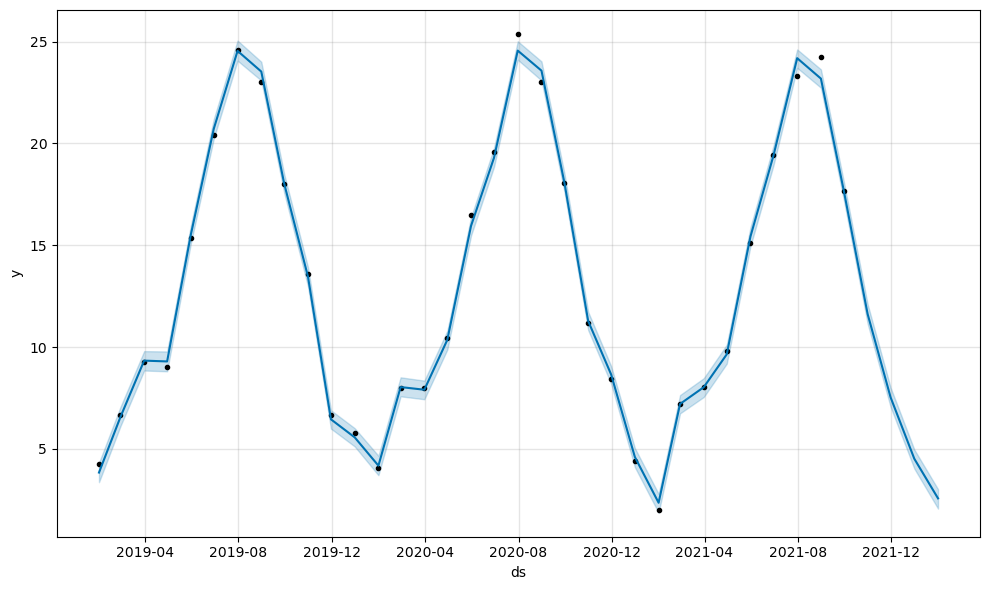

In [28]:
future = m.make_future_dataframe(periods=4, freq="M")

forecast = m.predict(future)

m.plot(forecast);

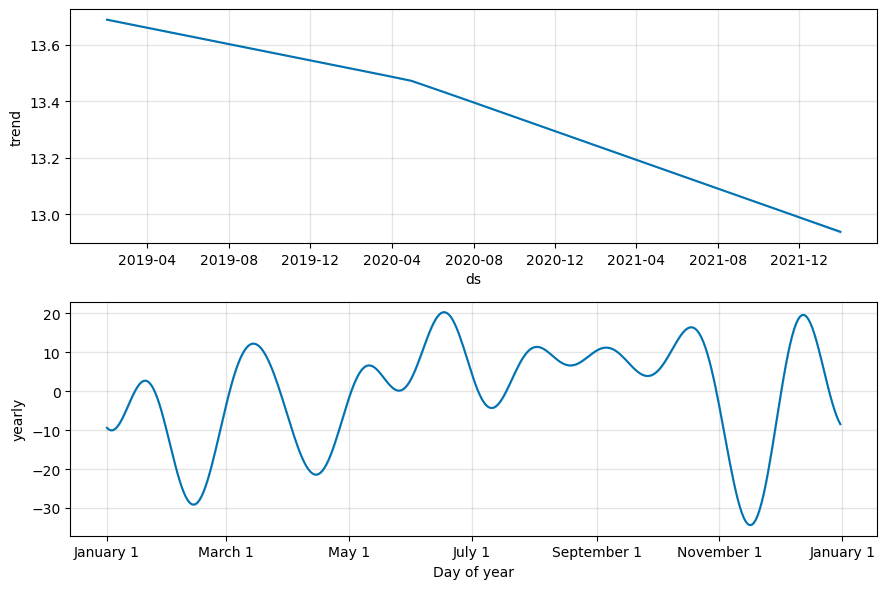

In [29]:
fig = m.plot_components(forecast)

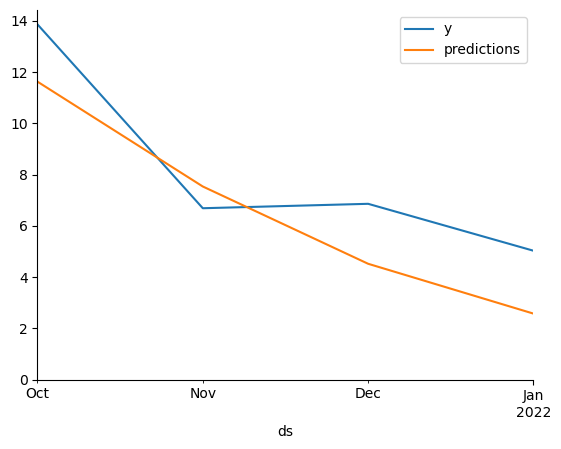

In [41]:
# Plot Forecast Vs. Actual

import seaborn as sns

(monthly_weather_test
 .assign(predictions = m.predict(future)["yhat"])
 .set_index("ds")
 .plot(ylim=0)
)

sns.despine()

In [39]:
# Performance Metrics

print(f" MAPE: {mape(monthly_weather_test['y'], m.predict(future).iloc[-4:, -1])}")
print(f" MAE: {mae(monthly_weather_test['y'], m.predict(future).iloc[-4:, -1])}")

 MAPE: 0.27943062244078987
 MAE: 1.9699780104129705
